In [295]:
# Tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.backend import clear_session
from tensorflow.python.ops import rnn, rnn_cell

# Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score


import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast
import pandas as pd
import numpy as np

# from google.colab import drive

In [296]:
#drive.mount('/content/drive')
%run arquitectures_rnn_mlp.ipynb

### Clear Previous Sessions

In [167]:
tf.keras.backend.clear_session()

### Test for a single iteration of the cross validation
##### fold1 - test
##### fold2 and fold3 - validation
##### fold3 - train

In [334]:
def test(nn_type, mfcc, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units):
    i = 1 #fold1 used for test

    # Define test set paths
    X_test_path = 'UrbanSound8K/audio/fold'+str(i)+'_4sec_mfccs_13/3D_array.npy'
    Y_test_path = 'UrbanSound8K/audio/fold'+str(i)+'_label/3D_array.npy'

    X_val_path1 = 'UrbanSound8K/audio/fold'+str((i+1-1) % 10 + 1)+f'_4sec_mfccs_{mfcc}/3D_array.npy'
    Y_val_path1 = 'UrbanSound8K/audio/fold'+str((i+1-1) % 10 + 1)+'_label/3D_array.npy'
    X_val_path2 = 'UrbanSound8K/audio/fold'+str((i+2-1) % 10 + 1)+f'_4sec_mfccs_{mfcc}/3D_array.npy'
    Y_val_path2 = 'UrbanSound8K/audio/fold'+str((i+2-1) % 10 + 1)+'_label/3D_array.npy'

    # Combine the validation paths
    X_val_paths = [X_val_path1, X_val_path2]
    Y_val_paths = [Y_val_path1, Y_val_path2]

    # # Define training set paths (all remaining folds)
    X_train_paths = ['UrbanSound8K/audio/fold'+str((j-1) % 10 + 1)+f'_4sec_mfccs_{mfcc}/3D_array.npy' for j in range(i+3, i+10)]
    Y_train_paths = ['UrbanSound8K/audio/fold'+str((j-1) % 10 + 1)+'_label/3D_array.npy' for j in range(i+3, i+10)]

    # Define test set paths
    X_test_path = f'UrbanSound8K/audio/fold{i}_4sec_mfccs_{mfcc}/3D_array.npy'
    Y_test_path = f'UrbanSound8K/audio/fold{i}_label/3D_array.npy'

    # Define validation set paths (wrapping around if i+2 > 10)
    X_val_path1 = f'UrbanSound8K/audio/fold{((i+1-1) % 10 + 1)}_4sec_mfccs_{mfcc}/3D_array.npy'
    Y_val_path1 = f'UrbanSound8K/audio/fold{((i+1-1) % 10 + 1)}_label/3D_array.npy'
    X_val_path2 = f'UrbanSound8K/audio/fold{((i+2-1) % 10 + 1)}_4sec_mfccs_{mfcc}/3D_array.npy'
    Y_val_path2 = f'UrbanSound8K/audio/fold{((i+2-1) % 10 + 1)}_label/3D_array.npy'

    # Combine the validation paths
    X_val_paths = [X_val_path1, X_val_path2]
    Y_val_paths = [Y_val_path1, Y_val_path2]

    # Define training set paths (all remaining folds)
    X_train_paths = [f'UrbanSound8K/audio/fold{((j-1) % 10 + 1)}_4sec_mfccs_{mfcc}/3D_array.npy' for j in range(i+3, i+11)]
    Y_train_paths = [f'UrbanSound8K/audio/fold{((j-1) % 10 + 1)}_label/3D_array.npy' for j in range(i+3, i+11)]

    # Load the datasets from the paths
    X_test = np.load(X_test_path)
    Y_test = np.load(Y_test_path)


    X_val1 = np.load(X_val_path1)
    X_val2 = np.load(X_val_path2)
    Y_val1 = np.load(Y_val_path1)
    Y_val2 = np.load(Y_val_path2)

    X_train = [np.load(path) for path in X_train_paths]
    Y_train = [np.load(path) for path in Y_train_paths]


    # Find the minimum size among all folds
    min_size = min([X_test.shape[0], X_val1.shape[0], X_val2.shape[0]] + [x.shape[0] for x in X_train])

    # Resize the data of each fold to the minimum size
    X_test_resized = X_test[:min_size]
    Y_test_resized = Y_test[:min_size]

    X_val1_resized = X_val1[:min_size]
    Y_val1_resized = Y_val1[:min_size]

    X_val2_resized = X_val2[:min_size]
    Y_val2_resized = Y_val2[:min_size]

    X_train_resized = [x[:min_size] for x in X_train]
    Y_train_resized = [y[:min_size] for y in Y_train]


    # Combine the validation sets
    X_test = X_test_resized
    Y_test = Y_test_resized
    X_val = np.concatenate((X_val1_resized, X_val2_resized), axis=2)
    Y_val = np.concatenate((Y_val1_resized, Y_val2_resized), axis=2)
    X_train = np.concatenate((X_train_resized[0], X_train_resized[1], X_train_resized[2], X_train_resized[3], X_train_resized[4], X_train_resized[5], X_train_resized[6]), axis=2)
    Y_train = np.concatenate((Y_train_resized[0], Y_train_resized[1], Y_train_resized[2], Y_train_resized[3], Y_train_resized[4], Y_train_resized[5], Y_train_resized[6]), axis=2)

    X_test = X_test.transpose(2,1,0)
    Y_test = Y_test.transpose(2,1,0)
    X_val = X_val.transpose(2,1,0)
    Y_val = Y_val.transpose(2,1,0)
    X_train = X_train.transpose(2,1,0)
    Y_train = Y_train.transpose(2,1,0)

    print("X_train shape:", X_train.shape)
    print("Y_train shape:", Y_train.shape)
    print("X_val shape:", X_val.shape)
    print("Y_val shape:", Y_val.shape)
    print(Y_train)
    print(Y_val)
    print(Y_test)

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    clear_session()  #-> em cada iteração o modelo começa a treinar “de zero”

    # Call de neural network
    input_shape = (751, mfcc)
    num_classes = 10

    #Neural Network Initialization
    if nn_type == "mlp":
        model = build_mlp_model(input_shape, num_classes, l2_lambda, n_hidden_units)

    elif nn_type == "rnn":
        model = build_rnn_model(input_shape, num_classes, l2_lambda, n_hidden_units)

    else:
        print("Introduce a valid neural network")





    model.summary() # print The neural network's architecture

    # Define the optimizer
    optimizer = legacy.SGD(learning_rate=learning_rate, momentum=momentum)

    #output layer
    model.add(layers.Dense(10, activation='softmax'))

    
    Y_train = np.squeeze(Y_train, axis=1)
    Y_val = np.squeeze(Y_val, axis=1)


    # clear_session()  # Clear the previous model


    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )


    history = model.fit(

        #training dataset
        X_train,
        Y_train,

        epochs=n_epochs,  # Number of epochs
        batch_size=batch_size, # Number of samples per batch

        #validation dataset
        validation_data=(X_val, Y_val)
    )

    print(history.history.keys())


    Y_train_classes = np.squeeze(Y_train).argmax(axis=-1) if Y_train.ndim == 3 else Y_train
    Y_val_classes = np.squeeze(Y_val).argmax(axis=-1) if Y_val.ndim == 3 else Y_val

    # Generate predictions
    Y_pred = model.predict(X_test)  # Predicted probabilities

    # Convert predictions to class labels
    Y_pred_classes = np.argmax(Y_pred, axis=-1)  # Convert probabilities to class labels

    # Flatten the one-hot encoded labels to 1D if they are 3D for Y_test
    Y_test_classes = np.squeeze(Y_test).argmax(axis=-1) if Y_test.ndim == 3 else Y_test


    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes)

    # Evaluate the model
    scores = model.evaluate(X_test, np.squeeze(Y_test), verbose=0)
    print(f"Test accuracy for fold {i}:", scores[1])
    


    # Calculate precision and recall
    precision = precision_score(Y_test_classes, Y_pred_classes, average='macro')
    recall = recall_score(Y_test_classes, Y_pred_classes, average='macro')

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")




    # plot training history
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss','test_loss'], loc='upper left')
    plt.show()



    return scores[1], history 

### Test hyperparameters manually

#### Default Combination

##### This is the baseline model with default hyperparameters: gives a point of comparison for future changes

X_train shape: (6045, 751, 13)
Y_train shape: (6045, 1, 10)
X_val shape: (1813, 751, 13)
Y_val shape: (1813, 1, 10)
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 ...

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9763)              0         
                                                                 
 dense (Dense)               (None, 128)               1249792   
                                                                 
 dropout (Dropout)           (None, 128)              

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


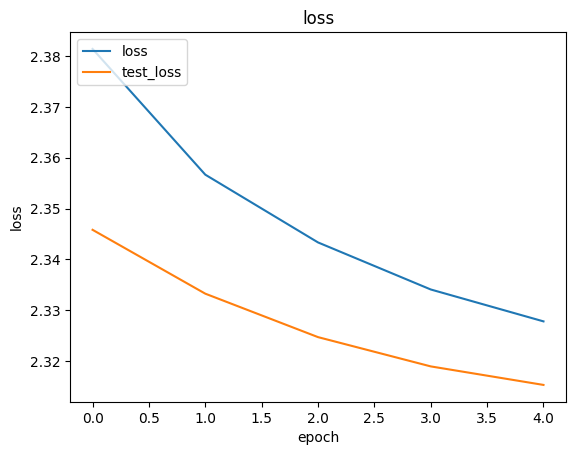

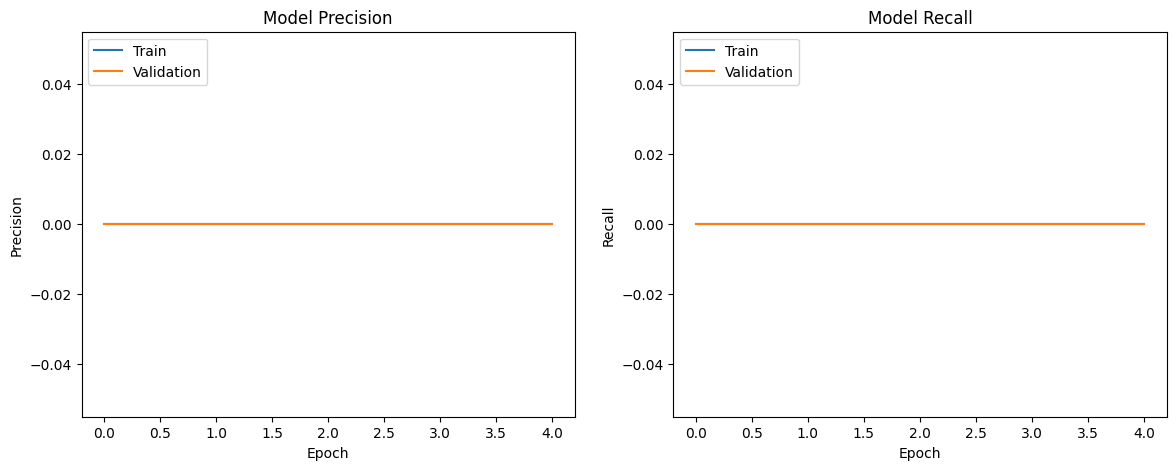

(0.13745704293251038, <keras.src.callbacks.History at 0x4e4487a30>)

In [335]:
n_epochs = 5 # More epochs with early stopping
batch_size = 64  # Slightly larger batch size
learning_rate = 0.001  # A bit lower learning rate
momentum = 0.9  # Keep the momentum if using SGD, else switch to Adam
n_hidden_units = 128  # Fewer units to start simple
l2_lambda = 0.0001  # Lower regularization to allow more learning

#####  Multilayer Perceptron

###### Test Function

In [ ]:
test_13_mlp = test("mlp", 13, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)  
test_25_mlp = test("mlp", 25, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)

print("For 13 coefficients: ", test_13_mlp)
print("For 25 coefficients: ", test_25_mlp)

###### Main Function

In [ ]:
main_13_mlp = main("mlp", 13, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)
main_25_mlp = main("mlp", 25, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)

print("For 13 coefficients: ", main_13_mlp)
print("For 25 coefficients: ", main_25_mlp)

#####  Reccurent Neural Network

###### Test Function

In [ ]:
test_13_rnn = test("rnn", 13, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)  
test_25_rnn = test("rnn", 25, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)

print("For 13 coefficients: ", test_13_rnn)
print("For 25 coefficients: ", test_25_rnn)

###### Main Function

In [ ]:
main_13_rnn = main("rnn", 13, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)
main_25_rnn = main("rnn", 25, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)

print("For 13 coefficients: ", main_13_rnn)
print("For 25 coefficients: ", main_25_rnn)

#### Changing learning rate

X_train shape: (6045, 751, 13)
Y_train shape: (6045, 1, 10)
X_val shape: (1813, 751, 13)
Y_val shape: (1813, 1, 10)
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 ...

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9763)              0         
                                                                 
 dense (Dense)               (None, 128)               1249792   
                                                                 
 dropout (Dropout)           (None, 128)              

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


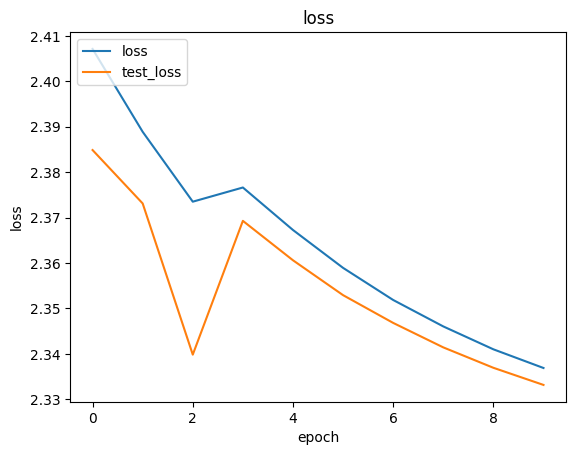

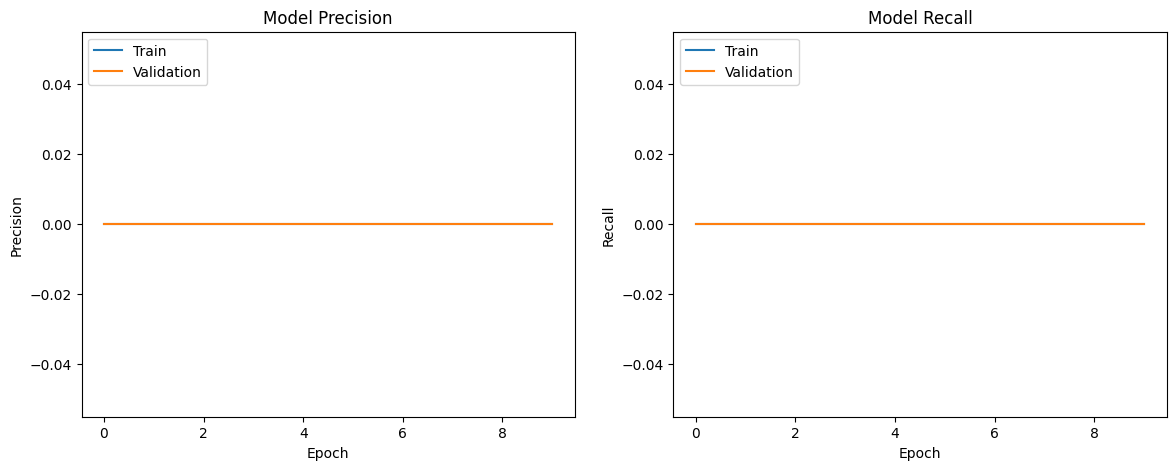

(0.11454753577709198, <keras.src.callbacks.History at 0x6aa5d4e80>)

In [331]:
n_epochs = 5
batch_size = 64  
learning_rate = [0.001, 0.0001, 0.00001]
momentum = 0.9  
n_hidden_units = 128  
l2_lambda = 0.0001  

#####  Multilayer Perceptron

###### Test Function

In [ ]:
for i in learning_rate:
    test_13_mlp = test("mlp", 13, n_epochs, batch_size, i, momentum, l2_lambda, n_hidden_units)  
    test_25_mlp = test("mlp", 25, n_epochs, batch_size, i, momentum, l2_lambda, n_hidden_units)
    print("For 13 coefficients with learning rate {i}: ", test_13_mlp)
    print("For 25 coefficients with learning rate {i}: ", test_25_mlp)

###### Main Function

In [ ]:
for i in learning_rate:
    main_13_mlp = main("mlp", 13, n_epochs, batch_size, i, momentum, l2_lambda, n_hidden_units)  
    main_25_mlp = main("mlp", 25, n_epochs, batch_size, i, momentum, l2_lambda, n_hidden_units)
    print("For 13 coefficients with learning rate {i}: ", main_13_mlp)
    print("For 25 coefficients with learning rate {i}: ", main_25_mlp)

#####  Reccurent Neural Network

###### Test Function

In [ ]:
for i in learning_rate:
    test_13_rnn = test("rnn", 13, n_epochs, batch_size, i, momentum, l2_lambda, n_hidden_units)  
    test_25_rnn = test("rnn", 25, n_epochs, batch_size, i, momentum, l2_lambda, n_hidden_units)
    print("For 13 coefficients with learning rate {i}: ", test_13_rnn)
    print("For 25 coefficients with learning rate {i}: ", test_25_rnn)

###### Main Function

In [ ]:
for i in learning_rate:
    main_13_rnn = main("rnn", 13, n_epochs, batch_size, i, momentum, l2_lambda, n_hidden_units)  
    main_25_rnn = main("rnn", 25, n_epochs, batch_size, i, momentum, l2_lambda, n_hidden_units)
    print("For 13 coefficients with learning rate {i}: ", main_13_rnn)
    print("For 25 coefficients with learning rate {i}: ", main_25_rnn)

#### Changing number of epochs

In [ ]:
n_epochs = [5, 10, 15]
batch_size = 64  
learning_rate = 0.001
momentum = 0.9  
n_hidden_units = 128  
l2_lambda = 0.0001  

In [ ]:

for i in n_epochs:

    test_13_mlp = test("mlp", 13, i, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)  
    test_25_mlp = test("mlp", 25, i, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)

    print("For 13 coefficients: ", test_13_mlp)
    print("For 25 coefficients: ", test_25_mlp)

In [ ]:

for i in n_epochs:

    main_13_mlp = main("mlp", 13, i, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)  
    main_25_mlp = main("mlp", 25, i, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)

    print("For 13 coefficients: ", main_13_mlp)
    print("For 25 coefficients: ", main_25_mlp)

In [ ]:

for i in n_epochs:

    test_13_rnn = test("rnn", 13, i, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)  
    test_25_rnn = test("rnn", 25, i, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)

    print("For 13 coefficients: ", test_13_rnn)
    print("For 25 coefficients: ", test_25_rnn)

In [ ]:

for i in n_epochs:

    main_13_rnn = main("mlp", 13, i, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)  
    main_25_rnn = main("mlp", 25, i, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)

    print("For 13 coefficients: ", main_13_rnn)
    print("For 25 coefficients: ", main_25_rnn)

In [ ]:
n_epochs = 5
batch_size = [64, 128, 252]
learning_rate = 0.001
momentum = 0.9  
n_hidden_units = 128  
l2_lambda = 0.0001  

In [ ]:

for i in batch_size:

    test_13_mlp = test("mlp", 13, n_epochs, i, learning_rate, momentum, l2_lambda, n_hidden_units)  
    test_25_mlp = test("mlp", 25, n_epochs, i, learning_rate, momentum, l2_lambda, n_hidden_units)

    print("For 13 coefficients: ", test_13_mlp)
    print("For 25 coefficients: ", test_25_mlp)

In [ ]:
for i in n_epochs:

    main_13_mlp = main("mlp", 13, n_epochs,, i, learning_rate, momentum, l2_lambda, n_hidden_units)  
    main_25_mlp = main("mlp", 25, i, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)

    print("For 13 coefficients: ", main_13_mlp)
    print("For 25 coefficients: ", main_25_mlp)

In [ ]:

for i in n_epochs:

    test_13_rnn = test("rnn", 13, i, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)  
    test_25_rnn = test("rnn", 25, i, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)

    print("For 13 coefficients: ", test_13_rnn)
    print("For 25 coefficients: ", test_25_rnn)

In [ ]:

for i in n_epochs:

    main_13_rnn = main("mlp", 13, i, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)  
    main_25_rnn = main("mlp", 25, i, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)

    print("For 13 coefficients: ", main_13_rnn)
    print("For 25 coefficients: ", main_25_rnn)

X_train shape: (6045, 751, 13)
Y_train shape: (6045, 1, 10)
X_val shape: (1813, 751, 13)
Y_val shape: (1813, 1, 10)
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 ...

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9763)              0         
                                                                 
 dense (Dense)               (None, 128)               1249792   
                                                                 
 dropout (Dropout)           (None, 128)              

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


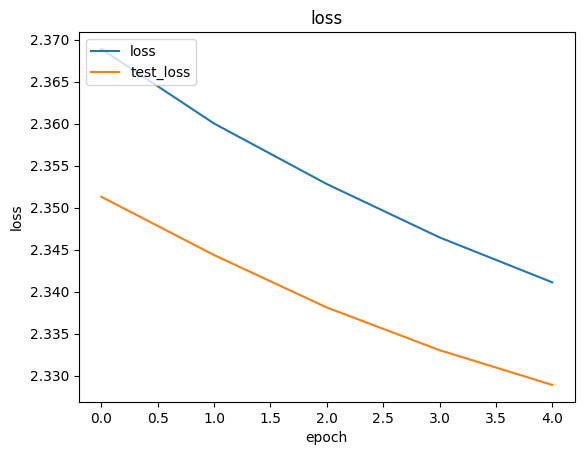

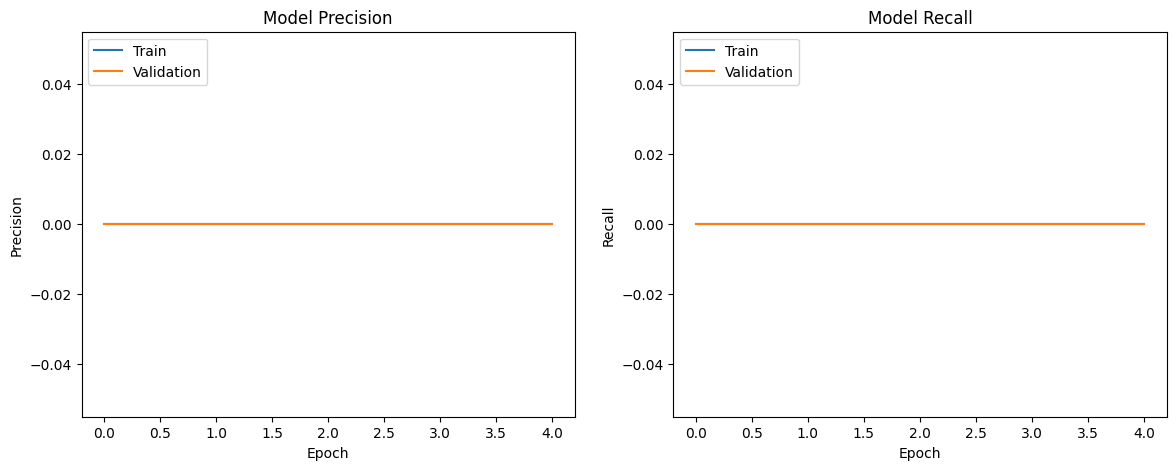

(0.13745704293251038, <keras.src.callbacks.History at 0x569d2bdf0>)

In [329]:
n_epochs = 15 # More epochs with early stopping
batch_size = 128  # Slightly larger batch size
learning_rate = 0.0005  # A bit lower learning rate
momentum = 0.99  # Keep the momentum if using SGD, else switch to Adam
n_hidden_units = 256  # Fewer units to start simple
l2_lambda = 0.001  # Lower regularization to allow more learning

test("mlp", 13, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)  

X_train shape: (6045, 751, 13)
Y_train shape: (6045, 1, 10)
X_val shape: (1813, 751, 13)
Y_val shape: (1813, 1, 10)
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 ...

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9763)              0         
                                                                 
 dense (Dense)               (None, 128)               1249792   
                                                                 
 dropout (Dropout)           (None, 128)              

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


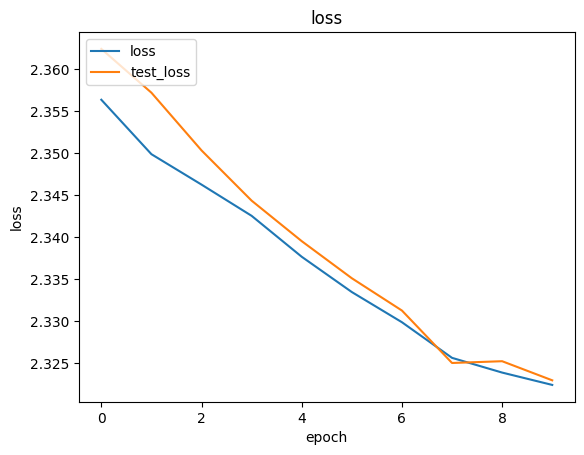

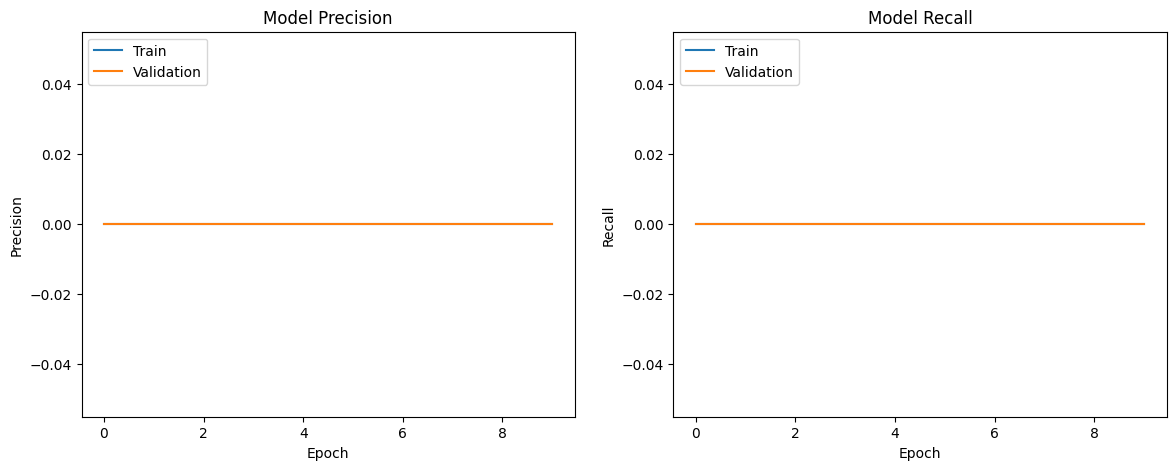

(0.12371134012937546, <keras.src.callbacks.History at 0x527280400>)

In [328]:
n_epochs = 10 # More epochs with early stopping
batch_size = 64  # Slightly larger batch size
learning_rate = 0.0005  # A bit lower learning rate
momentum = 0.9  # Keep the momentum if using SGD, else switch to Adam
n_hidden_units = 128  # Fewer units to start simple
l2_lambda = 0.0001  # Lower regularization to allow more learning

test("mlp", 13, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)    

##### Reccurent Neural Network

X_train shape: (6045, 751, 13)
Y_train shape: (6045, 1, 10)
X_val shape: (1813, 751, 13)
Y_val shape: (1813, 1, 10)
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 ...

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 751, 128)          72704     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 10)               

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


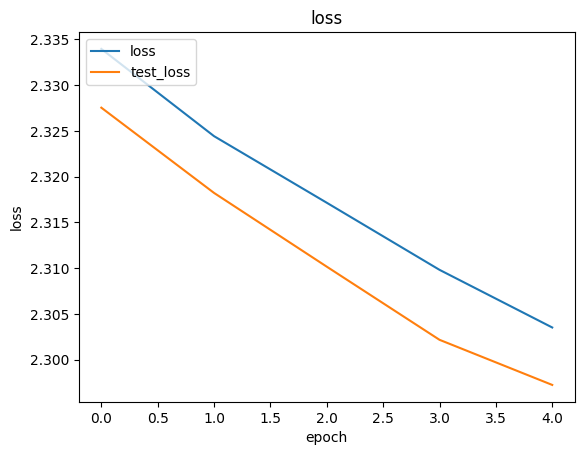

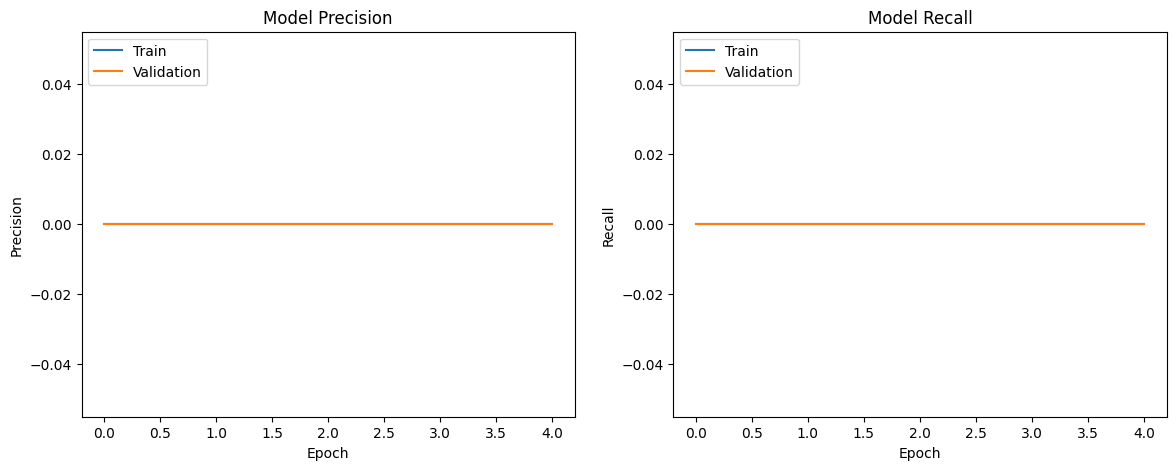

In [287]:
test("rnn", 13, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)

#### For 25 coefficients

##### Multilayer Perceptron

In [288]:
test("mlp", 25, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)

X_train shape: (6045, 751, 25)
Y_train shape: (6045, 1, 10)
X_val shape: (1813, 751, 25)
Y_val shape: (1813, 1, 10)
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 ...

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 18775)             0         
                                                                 
 dense (Dense)               (None, 128)               2403328   
                                                                 
 dropout (Dropout)           (None, 128)              

KeyboardInterrupt: 

##### Reccurent Neural Network

In [ ]:
test("rnn", 25, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)

### Main function

In [290]:
def main(nn_type, mfcc, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units):
    # General Confusion Matrix
    confusion_matrix_accumulated = np.zeros((10, 10))
    accuracies = []

    for i in range(1, 11):

        # Define test set paths
        X_test_path = 'UrbanSound8K/audio/fold'+str(i)+'_4sec_mfccs_13/3D_array.npy'
        Y_test_path = 'UrbanSound8K/audio/fold'+str(i)+'_label/3D_array.npy'

        X_val_path1 = 'UrbanSound8K/audio/fold'+str((i+1-1) % 10 + 1)+f'_4sec_mfccs_{mfcc}/3D_array.npy'
        Y_val_path1 = 'UrbanSound8K/audio/fold'+str((i+1-1) % 10 + 1)+'_label/3D_array.npy'
        X_val_path2 = 'UrbanSound8K/audio/fold'+str((i+2-1) % 10 + 1)+f'_4sec_mfccs_{mfcc}/3D_array.npy'
        Y_val_path2 = 'UrbanSound8K/audio/fold'+str((i+2-1) % 10 + 1)+'_label/3D_array.npy'

        # Combine the validation paths
        X_val_paths = [X_val_path1, X_val_path2]
        Y_val_paths = [Y_val_path1, Y_val_path2]

        # # Define training set paths (all remaining folds)
        X_train_paths = ['UrbanSound8K/audio/fold'+str((j-1) % 10 + 1)+f'_4sec_mfccs_{mfcc}/3D_array.npy' for j in range(i+3, i+10)]
        Y_train_paths = ['UrbanSound8K/audio/fold'+str((j-1) % 10 + 1)+'_label/3D_array.npy' for j in range(i+3, i+10)]

        # Define test set paths
        X_test_path = f'UrbanSound8K/audio/fold{i}_4sec_mfccs_{mfcc}/3D_array.npy'
        Y_test_path = f'UrbanSound8K/audio/fold{i}_label/3D_array.npy'

        # Define validation set paths (wrapping around if i+2 > 10)
        X_val_path1 = f'UrbanSound8K/audio/fold{((i+1-1) % 10 + 1)}_4sec_mfccs_{mfcc}/3D_array.npy'
        Y_val_path1 = f'UrbanSound8K/audio/fold{((i+1-1) % 10 + 1)}_label/3D_array.npy'
        X_val_path2 = f'UrbanSound8K/audio/fold{((i+2-1) % 10 + 1)}_4sec_mfccs_{mfcc}/3D_array.npy'
        Y_val_path2 = f'UrbanSound8K/audio/fold{((i+2-1) % 10 + 1)}_label/3D_array.npy'

        # Combine the validation paths
        X_val_paths = [X_val_path1, X_val_path2]
        Y_val_paths = [Y_val_path1, Y_val_path2]

        # Define training set paths (all remaining folds)
        X_train_paths = [f'UrbanSound8K/audio/fold{((j-1) % 10 + 1)}_4sec_mfccs_{mfcc}/3D_array.npy' for j in range(i+3, i+11)]
        Y_train_paths = [f'UrbanSound8K/audio/fold{((j-1) % 10 + 1)}_label/3D_array.npy' for j in range(i+3, i+11)]

        # Load the datasets from the paths
        X_test = np.load(X_test_path)
        Y_test = np.load(Y_test_path)


        X_val1 = np.load(X_val_path1)
        X_val2 = np.load(X_val_path2)
        Y_val1 = np.load(Y_val_path1)
        Y_val2 = np.load(Y_val_path2)

        X_train = [np.load(path) for path in X_train_paths]
        Y_train = [np.load(path) for path in Y_train_paths]

        
        # Encontrar o tamanho mínimo entre todos os folds
        min_size = min([X_test.shape[0], X_val1.shape[0], X_val2.shape[0]] + [x.shape[0] for x in X_train])

        # Redimensionar os dados de cada fold para o tamanho mínimo
        X_test_resized = X_test[:min_size]
        Y_test_resized = Y_test[:min_size]

        X_val1_resized = X_val1[:min_size]
        Y_val1_resized = Y_val1[:min_size]

        X_val2_resized = X_val2[:min_size]
        Y_val2_resized = Y_val2[:min_size]

        X_train_resized = [x[:min_size] for x in X_train]
        Y_train_resized = [y[:min_size] for y in Y_train]


        # Combine the validation sets
        X_test = X_test_resized
        Y_test = Y_test_resized
        X_val = np.concatenate((X_val1_resized, X_val2_resized), axis=2)
        Y_val = np.concatenate((Y_val1_resized, Y_val2_resized), axis=2)
        X_train = np.concatenate((X_train_resized[0], X_train_resized[1], X_train_resized[2], X_train_resized[3], X_train_resized[4], X_train_resized[5], X_train_resized[6]), axis=2)
        Y_train = np.concatenate((Y_train_resized[0], Y_train_resized[1], Y_train_resized[2], Y_train_resized[3], Y_train_resized[4], Y_train_resized[5], Y_train_resized[6]), axis=2)

        X_test = X_test.transpose(2,1,0)
        Y_test = Y_test.transpose(2,1,0)
        X_val = X_val.transpose(2,1,0)
        Y_val = Y_val.transpose(2,1,0)
        X_train = X_train.transpose(2,1,0)
        Y_train = Y_train.transpose(2,1,0)

        print("X_train shape:", X_train.shape)
        print("Y_train shape:", Y_train.shape)
        print("X_val shape:", X_val.shape)
        print("Y_val shape:", Y_val.shape)
        print(Y_train)
        print(Y_val)
        print(Y_test)


    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

        clear_session()  #-> em cada iteração o modelo começa a treinar “de zero”


        # Call de neural network
        input_shape = (751, mfcc)
        num_classes = 10

        #Neural Network Initialization
        if nn_type == "mlp":
            model = build_mlp_model(input_shape, num_classes, l2_lambda, n_hidden_units)

        elif nn_type == "rnn":
            model = build_rnn_model(input_shape, num_classes, l2_lambda, n_hidden_units)

        else:
            print("Introduce a valid neural network")


        model.summary() # print The neural network's architecture
        
        optimizer = legacy.SGD(learning_rate=learning_rate, momentum=momentum)

        #output layer
        model.add(layers.Dense(10, activation='softmax'))

        #fiz isto pq estava a dar erro e não sei porquê, mas funciona para rnn
        Y_train = np.squeeze(Y_train, axis=1)
        Y_val = np.squeeze(Y_val, axis=1)


        # Compile the model.
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )


        history = model.fit(

            #training dataset
            X_train,
            Y_train,

            epochs=n_epochs,  # Number of epochs
            batch_size=batch_size, # Number of samples per batch

            #validation dataset
            validation_data=(X_val, Y_val)
        )

        print(history.history.keys())


    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        # Evaluate the model
        Y_train_classes = np.squeeze(Y_train).argmax(axis=-1) if Y_train.ndim == 3 else Y_train
        Y_val_classes = np.squeeze(Y_val).argmax(axis=-1) if Y_val.ndim == 3 else Y_val

        # Generate predictions
        Y_pred = model.predict(X_test)  # Predicted probabilities

        # Convert predictions to class labels
        Y_pred_classes = np.argmax(Y_pred, axis=-1)  # Convert probabilities to class labels

        # Flatten the one-hot encoded labels to 1D if they are 3D for Y_test
        Y_test_classes = np.squeeze(Y_test).argmax(axis=-1) if Y_test.ndim == 3 else Y_test

        # Calculate the confusion matrix
        conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes)
        confusion_matrix_accumulated += conf_matrix

        # Evaluate the model, ensuring the Y_test used here matches the format expected by the model
        scores = model.evaluate(X_test, np.squeeze(Y_test), verbose=0)
        print(f"Test accuracy for fold {i}:", scores[1])


        # Calculate precision and recall
        precision = precision_score(Y_test_classes, Y_pred_classes, average='macro')
        recall = recall_score(Y_test_classes, Y_pred_classes, average='macro')

        print(f"Precision: {precision}")
        print(f"Recall: {recall}")

        accuracies.append(scores[1])
        print(f"Test accuracy for fold {i}:", scores[1])


    print("General Confusion Matrix:")
    print(confusion_matrix_accumulated)

    print("Accuracies' Average:")
    print(np.mean(accuracies))

    print("Standard Deviation of the accuracies:")
    print(np.std(accuracies))

    # Bar plot to visualize the accuracies
    plt.bar(range(1, 11), accuracies)
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Across Iterations')
    plt.show()

    # plot training history
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss','test_loss'], loc='upper left')
    plt.show()

#### For 13 coefficients

##### Multilayer Perceptron

X_train shape: (6045, 751, 13)
Y_train shape: (6045, 1, 10)
X_val shape: (1813, 751, 13)
Y_val shape: (1813, 1, 10)
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 ...

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9763)              0         
                                                                 
 dense (Dense)               (None, 128)               1249792   
                                                                 
 dropout (Dropout)           (None, 128)              

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9763)              0         
                                                                 
 dense (Dense)               (None, 128)               1249792   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 10)                1

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1284106 (4.90 MB)
Trainable params: 1284106 (4.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
92/92 [==============================] - 2s 11ms/step - loss: 2.3664 - accuracy: 0.0946 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3521 - val_accuracy: 0.1246 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
92/92 [==============================] - 1s 6ms/step - loss: 2.3377 - accuracy: 0.1088 - precision: 0.0000e+00 - recall:

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1284106 (4.90 MB)
Trainable params: 1284106 (4.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
94/94 [==============================] - 2s 12ms/step - loss: 2.3763 - accuracy: 0.1200 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3692 - val_accuracy: 0.1137 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
94/94 [==============================] - 1s 6ms/step - loss: 2.3643 - accuracy: 0.1174 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3616 - val_accuracy: 0.1137 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
94/94 [========

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 flatten (Flatten)           (None, 9763)              0         
                                                                 
 dense (Dense)               (None, 128)               1249792   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1284106 (4.90 MB)
Trainable params: 1284106 (4.90 MB)
Non-trai

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1284106 (4.90 MB)
Trainable params: 1284106 (4.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
98/98 [==============================] - 2s 11ms/step - loss: 2.3588 - accuracy: 0.1132 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3466 - val_accuracy: 0.1217 - val_precision: 0.0000e+00 - val_recall: 0.0000e+0

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1284106 (4.90 MB)
Trainable params: 1284106 (4.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
98/98 [==============================] - 2s 11ms/step - loss: 2.3800 - accuracy: 0.1089 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3873 - val_accuracy: 0.1092 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
98/98 [==============================] - 1s 5ms/step - loss: 2.3900 - accuracy: 0.1111 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3932 - val_accuracy: 0.1234 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
98/98 [========

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9763)              0         
                                                                 
 dense (Dense)               (None, 128)               1249792   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 10)                1

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1284106 (4.90 MB)
Trainable params: 1284106 (4.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
97/97 [==============================] - 2s 12ms/step - loss: 2.3468 - accuracy: 0.1209 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3308 - val_accuracy: 0.1170 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
97/97 [==============================] - 1s 6ms/step - loss: 2.3375 - accuracy: 0.1133 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3263 - val_accuracy: 0.1170 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
97/97 [==============================] - 1s 6ms/step - loss: 2.3338 - accuracy: 0.1118 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3224 - val_accuracy: 0.1170 - val_precision: 0.0000e+00 - val_recal

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9763)              0         
                                                                 
 dense (Dense)               (None, 128)               1249792   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 10)                1

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


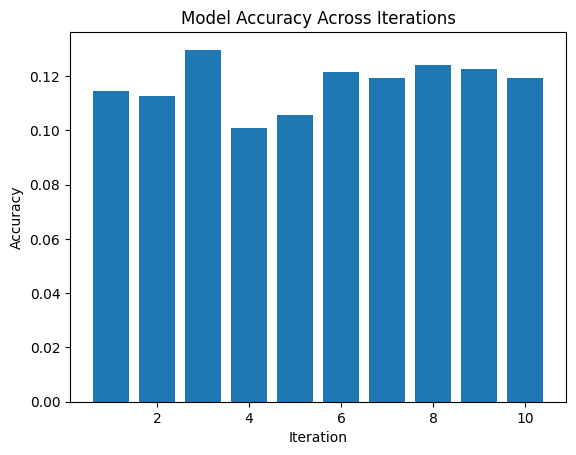

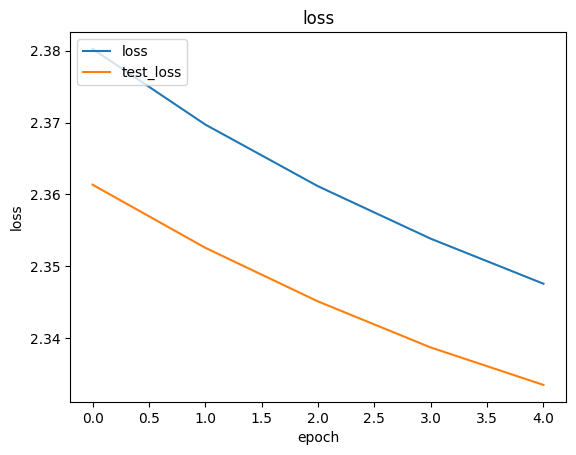

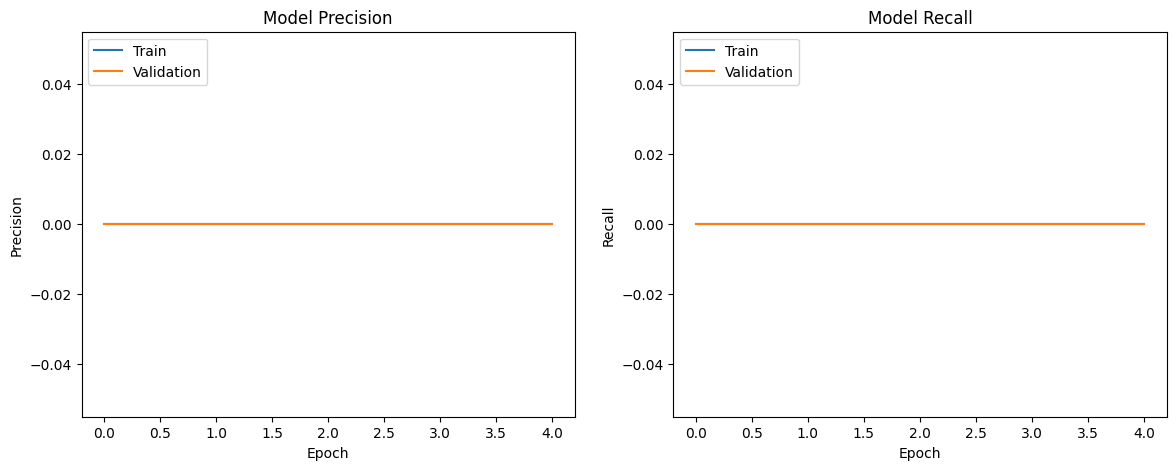

In [292]:
main("mlp", 13, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)

##### Reccurent Neural Network

In [ ]:
main("rnn", 13, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)

#### For 25 coefficients

##### Multilayer Perceptron

In [ ]:
main("mlp", 25, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)

##### Reccurent Neural Network

In [ ]:
main("rnn", 25, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)

## The Best Hiperparameters 

### MLP - Mfcc=13 - test function

In [315]:
def best_hiperparameter_test(nn_type, mfcc, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units):

    i = 1 #fold1 used for test

    # Define test set paths
    X_test_path = 'UrbanSound8K/audio/fold'+str(i)+'_4sec_mfccs_13/3D_array.npy'
    Y_test_path = 'UrbanSound8K/audio/fold'+str(i)+'_label/3D_array.npy'

    X_val_path1 = 'UrbanSound8K/audio/fold'+str((i+1-1) % 10 + 1)+f'_4sec_mfccs_{mfcc}/3D_array.npy'
    Y_val_path1 = 'UrbanSound8K/audio/fold'+str((i+1-1) % 10 + 1)+'_label/3D_array.npy'
    X_val_path2 = 'UrbanSound8K/audio/fold'+str((i+2-1) % 10 + 1)+f'_4sec_mfccs_{mfcc}/3D_array.npy'
    Y_val_path2 = 'UrbanSound8K/audio/fold'+str((i+2-1) % 10 + 1)+'_label/3D_array.npy'

    # Combine the validation paths
    X_val_paths = [X_val_path1, X_val_path2]
    Y_val_paths = [Y_val_path1, Y_val_path2]

    # # Define training set paths (all remaining folds)
    X_train_paths = ['UrbanSound8K/audio/fold'+str((j-1) % 10 + 1)+f'_4sec_mfccs_{mfcc}/3D_array.npy' for j in range(i+3, i+10)]
    Y_train_paths = ['UrbanSound8K/audio/fold'+str((j-1) % 10 + 1)+'_label/3D_array.npy' for j in range(i+3, i+10)]

    # Define test set paths
    X_test_path = f'UrbanSound8K/audio/fold{i}_4sec_mfccs_{mfcc}/3D_array.npy'
    Y_test_path = f'UrbanSound8K/audio/fold{i}_label/3D_array.npy'

    # Define validation set paths (wrapping around if i+2 > 10)
    X_val_path1 = f'UrbanSound8K/audio/fold{((i+1-1) % 10 + 1)}_4sec_mfccs_{mfcc}/3D_array.npy'
    Y_val_path1 = f'UrbanSound8K/audio/fold{((i+1-1) % 10 + 1)}_label/3D_array.npy'
    X_val_path2 = f'UrbanSound8K/audio/fold{((i+2-1) % 10 + 1)}_4sec_mfccs_{mfcc}/3D_array.npy'
    Y_val_path2 = f'UrbanSound8K/audio/fold{((i+2-1) % 10 + 1)}_label/3D_array.npy'

    # Combine the validation paths
    X_val_paths = [X_val_path1, X_val_path2]
    Y_val_paths = [Y_val_path1, Y_val_path2]

    # Define training set paths (all remaining folds)
    X_train_paths = [f'UrbanSound8K/audio/fold{((j-1) % 10 + 1)}_4sec_mfccs_{mfcc}/3D_array.npy' for j in range(i+3, i+11)]
    Y_train_paths = [f'UrbanSound8K/audio/fold{((j-1) % 10 + 1)}_label/3D_array.npy' for j in range(i+3, i+11)]

    # Load the datasets from the paths
    X_test = np.load(X_test_path)
    Y_test = np.load(Y_test_path)


    X_val1 = np.load(X_val_path1)
    X_val2 = np.load(X_val_path2)
    Y_val1 = np.load(Y_val_path1)
    Y_val2 = np.load(Y_val_path2)

    X_train = [np.load(path) for path in X_train_paths]
    Y_train = [np.load(path) for path in Y_train_paths]


    # Encontrar o tamanho mínimo entre todos os folds
    min_size = min([X_test.shape[0], X_val1.shape[0], X_val2.shape[0]] + [x.shape[0] for x in X_train])

    # Redimensionar os dados de cada fold para o tamanho mínimo
    X_test_resized = X_test[:min_size]
    Y_test_resized = Y_test[:min_size]

    X_val1_resized = X_val1[:min_size]
    Y_val1_resized = Y_val1[:min_size]

    X_val2_resized = X_val2[:min_size]
    Y_val2_resized = Y_val2[:min_size]

    X_train_resized = [x[:min_size] for x in X_train]
    Y_train_resized = [y[:min_size] for y in Y_train]


    # Combine the validation sets
    X_test = X_test_resized
    Y_test = Y_test_resized
    X_val = np.concatenate((X_val1_resized, X_val2_resized), axis=2)
    Y_val = np.concatenate((Y_val1_resized, Y_val2_resized), axis=2)
    X_train = np.concatenate((X_train_resized[0], X_train_resized[1], X_train_resized[2], X_train_resized[3], X_train_resized[4], X_train_resized[5], X_train_resized[6]), axis=2)
    Y_train = np.concatenate((Y_train_resized[0], Y_train_resized[1], Y_train_resized[2], Y_train_resized[3], Y_train_resized[4], Y_train_resized[5], Y_train_resized[6]), axis=2)

    X_test = X_test.transpose(2,1,0)
    Y_test = Y_test.transpose(2,1,0)
    X_val = X_val.transpose(2,1,0)
    Y_val = Y_val.transpose(2,1,0)
    X_train = X_train.transpose(2,1,0)
    Y_train = Y_train.transpose(2,1,0)

    # print("X_train shape:", X_train.shape)
    # print("Y_train shape:", Y_train.shape)
    # print("X_val shape:", X_val.shape)
    # print("Y_val shape:", Y_val.shape)
    # print(Y_train)
    # print(Y_val)
    # print(Y_test)

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # Call de neural network
    input_shape = (751, mfcc)
    num_classes = 10

    #Neural Network Initialization
    if nn_type == "mlp":
        model = build_mlp_model(input_shape, num_classes, l2_lambda, n_hidden_units)

    elif nn_type == "rnn":
        model = build_rnn_model(input_shape, num_classes, l2_lambda, n_hidden_units)

    else:
        print("Introduce a valid neural network")





    model.summary() # print The neural network's architecture

    # Define the optimizer
    #AQUI O SGD SOZINHO FAZ COM QUE SEJA TUDO MUITO LENTO, ENTÃO TROQUEI PARA LEGACY.SGD
    optimizer = legacy.SGD(learning_rate=learning_rate, momentum=momentum)

    #output layer
    model.add(layers.Dense(10, activation='softmax'))

    #fiz isto pq estava a dar erro e não sei porquê, mas funciona para rnn
    Y_train = np.squeeze(Y_train, axis=1)
    Y_val = np.squeeze(Y_val, axis=1)   


    clear_session()  # Clear the previous model


    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(), Recall()]
    )


    history = model.fit(

        #training dataset
        X_train,
        Y_train,

        epochs=n_epochs,  # Number of epochs
        batch_size=batch_size, # Number of samples per batch

        #validation dataset
        validation_data=(X_val, Y_val)
    )

    # print(history.history.keys())


    Y_train_classes = np.squeeze(Y_train).argmax(axis=-1) if Y_train.ndim == 3 else Y_train
    Y_val_classes = np.squeeze(Y_val).argmax(axis=-1) if Y_val.ndim == 3 else Y_val

    # Generate predictions
    Y_pred = model.predict(X_test)  # Predicted probabilities

    # Convert predictions to class labels
    Y_pred_classes = np.argmax(Y_pred, axis=-1)  # Convert probabilities to class labels

    # Flatten the one-hot encoded labels to 1D if they are 3D for Y_test
    Y_test_classes = np.squeeze(Y_test).argmax(axis=-1) if Y_test.ndim == 3 else Y_test

    # Make sure the confusion matrix function is correctly imported
    from sklearn.metrics import confusion_matrix

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes)

    # Evaluate the model, ensuring the Y_test used here matches the format expected by the model
    scores = model.evaluate(X_test, np.squeeze(Y_test), verbose=0)
    print(f"Test accuracy for fold {i}:", scores[1])
    


    from sklearn.metrics import precision_score, recall_score

    # Calculate precision and recall
    precision = precision_score(Y_test_classes, Y_pred_classes, average='macro')
    recall = recall_score(Y_test_classes, Y_pred_classes, average='macro')

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")




    return scores[1], history 
    

In [317]:
# Hiperparâmetros a variar
epochs_list = [5, 10, 15]
batch_size_list = [32, 64, 128]
learning_rates = [0.0001, 0.0005, 0.001]
momentums = [0.8, 0.9, 0.95]
hidden_units_list = [64, 128, 256]
l2_lambdas = [0.0001, 0.001, 0.01]

# Melhor pontuação, parâmetros e histórico
best_score = 0
best_params = {}
best_history = None

for n_epochs in epochs_list:
    for batch_size in batch_size_list:
        for learning_rate in learning_rates:
            for momentum in momentums:
                for n_hidden_units in hidden_units_list:
                    for l2_lambda in l2_lambdas:
                    
                        test_accuracy, history = best_hiperparameter_test("mlp", 13, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)
                        if test_accuracy > best_score:
                            best_score = test_accuracy
                            best_params = {'n_epochs': n_epochs, 'batch_size': batch_size, 'learning_rate': learning_rate, 'momentum': momentum, 'l2_lambda': l2_lambda, 'n_hidden_units': n_hidden_units}
                            best_history = history

# Exibir os melhores hiperparâmetros e pontuação
print("Melhores hiperparâmetros:", best_params)
print("Melhor pontuação:", best_score)

# Plotar o gráfico com os melhores hiperparâmetros
if best_history:
    plt.plot(best_history.history['accuracy'])
    plt.plot(best_history.history['val_accuracy'])
    # Configurações adicionais do gráfico
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9763)              0         
                                                                 
 dense (Dense)               (None, 64)                624896    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 10)                6

KeyboardInterrupt: 

### MLP - Mfcc=25 - test function

In [ ]:
# Hiperparâmetros a variar
epochs_list = [5, 10, 15]
batch_size_list = [32, 64, 128]
learning_rates = [0.0001, 0.0005, 0.001]
momentums = [0.8, 0.9, 0.95]
hidden_units_list = [64, 128, 256]
l2_lambdas = [0.0001, 0.001, 0.01]

# Melhor pontuação e parâmetros
best_score = 0
best_params = {}

for n_epochs in epochs_list:
    for batch_size in batch_size_list:
        for learning_rate in learning_rates:
            for momentum in momentums:
                for n_hidden_units in hidden_units_list:
                    for l2_lambda in l2_lambdas:
                        # Chame sua função de teste aqui com os hiperparâmetros atuais
                        test_accuracy = test("mlp", 25, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)
                        
                        # Verifique se este modelo tem melhor pontuação
                        if test_accuracy > best_score:
                            best_score = test_accuracy
                            best_params = {
                                'n_epochs': n_epochs,
                                'batch_size': batch_size,
                                'learning_rate': learning_rate,
                                'momentum': momentum,
                                'n_hidden_units': n_hidden_units,
                                'l2_lambda': l2_lambda
                            }

# Exibir os melhores hiperparâmetros e pontuação
print("Melhores hiperparâmetros:", best_params)
print("Melhor pontuação:", best_score)


### MLP - Mfcc=13 - main function

In [318]:
# Hiperparâmetros a variar
epochs_list = [5, 10, 15]
batch_size_list = [32, 64, 128]
learning_rates = [0.0001, 0.0005, 0.001]
momentums = [0.8, 0.9, 0.95]
hidden_units_list = [64, 128, 256]
l2_lambdas = [0.0001, 0.001, 0.01]

# Melhor pontuação e parâmetros
best_score = 0
best_params = {}

for n_epochs in epochs_list:
    for batch_size in batch_size_list:
        for learning_rate in learning_rates:
            for momentum in momentums:
                for n_hidden_units in hidden_units_list:
                    for l2_lambda in l2_lambdas:
                        # Chame sua função de teste aqui com os hiperparâmetros atuais
                        test_accuracy = main("mlp", 13, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)
                        
                        # Verifique se este modelo tem melhor pontuação
                        if test_accuracy > best_score:
                            best_score = test_accuracy
                            best_params = {
                                'n_epochs': n_epochs,
                                'batch_size': batch_size,
                                'learning_rate': learning_rate,
                                'momentum': momentum,
                                'n_hidden_units': n_hidden_units,
                                'l2_lambda': l2_lambda
                            }

# Exibir os melhores hiperparâmetros e pontuação
print("Melhores hiperparâmetros:", best_params)
print("Melhor pontuação:", best_score)


X_train shape: (6045, 751, 13)
Y_train shape: (6045, 1, 10)
X_val shape: (1813, 751, 13)
Y_val shape: (1813, 1, 10)
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 ...

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9763)              0         
                                                                 
 dense (Dense)               (None, 64)                624896    
                                                                 
 dropout (Dropout)           (None, 64)               

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape: (5928, 751, 13)
Y_train shape: (5928, 1, 10)
X_val shape: (1915, 751, 13)
Y_val shape: (1915, 1, 10)
[[[0 0 0 ... 0 0 0]]

 [[0 0 1 ... 0 0 0]]

 [[0 0 1 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9763)              0         
                                                                 
 dense (Dense)               (None, 64)                624896    
                                                                 
 dropout (Dropout)           (None, 64)               

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
184/184 [==============================] - 1s 4ms/step - loss: 2.3277 - accuracy: 0.1202 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3591 - val_accuracy: 0.1038 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
184/184 [==============================] - 1s 3ms/step - loss: 2.3219 - accuracy: 0.1201 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3578 - val_accuracy: 0.1044 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
184/184 [==============================] - 1s 3ms/step - loss: 2.3190 - accuracy: 0.1211 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3553 - val_accuracy: 0.1080 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
184/184 [==============================] - 1s 3ms/step - loss: 2.3148 - accuracy: 0.1267 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3495 - val_accuracy: 0.1205 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
184/184 [=========================

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape: (5982, 751, 13)
Y_train shape: (5982, 1, 10)
X_val shape: (1759, 751, 13)
Y_val shape: (1759, 1, 10)
[[[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 1 ... 0 0 0]]

 [[0 0 1 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9763)              0         
                                                                 
 dense (Dense)               (None, 64)                624896    
                                                                 
 dropout (Dropout)           (None, 64)               

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9763)              0         
                                                                 
 dense (Dense)               (None, 64)                624896    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 10)                6

KeyboardInterrupt: 

### MLP - Mfcc=25 - main function

In [ ]:
# Hiperparâmetros a variar
epochs_list = [5, 10, 15]
batch_size_list = [32, 64, 128]
learning_rates = [0.0001, 0.0005, 0.001]
momentums = [0.8, 0.9, 0.95]
hidden_units_list = [64, 128, 256]
l2_lambdas = [0.0001, 0.001, 0.01]

# Melhor pontuação e parâmetros
best_score = 0
best_params = {}

for n_epochs in epochs_list:
    for batch_size in batch_size_list:
        for learning_rate in learning_rates:
            for momentum in momentums:
                for n_hidden_units in hidden_units_list:
                    for l2_lambda in l2_lambdas:
                        # Chame sua função de teste aqui com os hiperparâmetros atuais
                        test_accuracy = main("mlp", 25, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)
                        
                        # Verifique se este modelo tem melhor pontuação
                        if test_accuracy > best_score:
                            best_score = test_accuracy
                            best_params = {
                                'n_epochs': n_epochs,
                                'batch_size': batch_size,
                                'learning_rate': learning_rate,
                                'momentum': momentum,
                                'n_hidden_units': n_hidden_units,
                                'l2_lambda': l2_lambda
                            }

# Exibir os melhores hiperparâmetros e pontuação
print("Melhores hiperparâmetros:", best_params)
print("Melhor pontuação:", best_score)


### RNN - Mfcc=13 - test function

In [ ]:
# Hiperparâmetros a variar
epochs_list = [5, 10, 15]
batch_size_list = [32, 64, 128]
learning_rates = [0.0001, 0.0005, 0.001]
momentums = [0.8, 0.9, 0.95]
hidden_units_list = [64, 128, 256]
l2_lambdas = [0.0001, 0.001, 0.01]

# Melhor pontuação e parâmetros
best_score = 0
best_params = {}

for n_epochs in epochs_list:
    for batch_size in batch_size_list:
        for learning_rate in learning_rates:
            for momentum in momentums:
                for n_hidden_units in hidden_units_list:
                    for l2_lambda in l2_lambdas:
                        # Chame sua função de teste aqui com os hiperparâmetros atuais
                        test_accuracy = test("rnn", 13, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)
                        
                        # Verifique se este modelo tem melhor pontuação
                        if test_accuracy > best_score:
                            best_score = test_accuracy
                            best_params = {
                                'n_epochs': n_epochs,
                                'batch_size': batch_size,
                                'learning_rate': learning_rate,
                                'momentum': momentum,
                                'n_hidden_units': n_hidden_units,
                                'l2_lambda': l2_lambda
                            }

# Exibir os melhores hiperparâmetros e pontuação
print("Melhores hiperparâmetros:", best_params)
print("Melhor pontuação:", best_score)


### RNN - Mfcc=25 - test function

In [ ]:
# Hiperparâmetros a variar
epochs_list = [5, 10, 15]
batch_size_list = [32, 64, 128]
learning_rates = [0.0001, 0.0005, 0.001]
momentums = [0.8, 0.9, 0.95]
hidden_units_list = [64, 128, 256]
l2_lambdas = [0.0001, 0.001, 0.01]

# Melhor pontuação e parâmetros
best_score = 0
best_params = {}

for n_epochs in epochs_list:
    for batch_size in batch_size_list:
        for learning_rate in learning_rates:
            for momentum in momentums:
                for n_hidden_units in hidden_units_list:
                    for l2_lambda in l2_lambdas:
                        # Chame sua função de teste aqui com os hiperparâmetros atuais
                        test_accuracy = test("rnn", 25, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)
                        
                        # Verifique se este modelo tem melhor pontuação
                        if test_accuracy > best_score:
                            best_score = test_accuracy
                            best_params = {
                                'n_epochs': n_epochs,
                                'batch_size': batch_size,
                                'learning_rate': learning_rate,
                                'momentum': momentum,
                                'n_hidden_units': n_hidden_units,
                                'l2_lambda': l2_lambda
                            }

# Exibir os melhores hiperparâmetros e pontuação
print("Melhores hiperparâmetros:", best_params)
print("Melhor pontuação:", best_score)


### RNN - Mfcc=13 - main function

In [ ]:
# Hiperparâmetros a variar
epochs_list = [5, 10, 15]
batch_size_list = [32, 64, 128]
learning_rates = [0.0001, 0.0005, 0.001]
momentums = [0.8, 0.9, 0.95]
hidden_units_list = [64, 128, 256]
l2_lambdas = [0.0001, 0.001, 0.01]

# Melhor pontuação e parâmetros
best_score = 0
best_params = {}

for n_epochs in epochs_list:
    for batch_size in batch_size_list:
        for learning_rate in learning_rates:
            for momentum in momentums:
                for n_hidden_units in hidden_units_list:
                    for l2_lambda in l2_lambdas:
                        # Chame sua função de teste aqui com os hiperparâmetros atuais
                        test_accuracy = main("rnn", 13, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)
                        
                        # Verifique se este modelo tem melhor pontuação
                        if test_accuracy > best_score:
                            best_score = test_accuracy
                            best_params = {
                                'n_epochs': n_epochs,
                                'batch_size': batch_size,
                                'learning_rate': learning_rate,
                                'momentum': momentum,
                                'n_hidden_units': n_hidden_units,
                                'l2_lambda': l2_lambda
                            }

# Exibir os melhores hiperparâmetros e pontuação
print("Melhores hiperparâmetros:", best_params)
print("Melhor pontuação:", best_score)


### RNN - Mfcc=25 - main function

In [ ]:
# Hiperparâmetros a variar
epochs_list = [5, 10, 15]
batch_size_list = [32, 64, 128]
learning_rates = [0.0001, 0.0005, 0.001]
momentums = [0.8, 0.9, 0.95]
hidden_units_list = [64, 128, 256]
l2_lambdas = [0.0001, 0.001, 0.01]

# Melhor pontuação e parâmetros
best_score = 0
best_params = {}

for n_epochs in epochs_list:
    for batch_size in batch_size_list:
        for learning_rate in learning_rates:
            for momentum in momentums:
                for n_hidden_units in hidden_units_list:
                    for l2_lambda in l2_lambdas:
                        # Chame sua função de teste aqui com os hiperparâmetros atuais
                        test_accuracy = test("rnn", 25, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)
                        
                        # Verifique se este modelo tem melhor pontuação
                        if test_accuracy > best_score:
                            best_score = test_accuracy
                            best_params = {
                                'n_epochs': n_epochs,
                                'batch_size': batch_size,
                                'learning_rate': learning_rate,
                                'momentum': momentum,
                                'n_hidden_units': n_hidden_units,
                                'l2_lambda': l2_lambda
                            }

# Exibir os melhores hiperparâmetros e pontuação
print("Melhores hiperparâmetros:", best_params)
print("Melhor pontuação:", best_score)


# BONUS

In [215]:
def generate_adversarial_examples(X, model, epsilon=0.01):
    # Generate predictions for the original data
    original_predictions = model.predict(X)
    original_classes = np.argmax(original_predictions, axis=1)

    # Add small noise to the original data
    noise = np.random.normal(0, epsilon, X.shape)
    adversarial_X = X + noise

    # Ensure the data still falls within valid MFCC range
    adversarial_X = np.clip(adversarial_X, -1, 1)

    # Generate predictions for the adversarial data
    adversarial_predictions = model.predict(adversarial_X)
    adversarial_classes = np.argmax(adversarial_predictions, axis=1)

    return adversarial_X, original_classes, adversarial_classes


In [223]:

def bonus_main(nn_type, mfcc, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units):
    # General Confusion Matrix
    confusion_matrix_accumulated = np.zeros((10, 10))
    accuracies = []

    for i in range(1, 11):

        # Define test set paths
        X_test_path = 'UrbanSound8K/audio/fold'+str(i)+'_4sec_mfccs_13/3D_array.npy'
        Y_test_path = 'UrbanSound8K/audio/fold'+str(i)+'_label/3D_array.npy'

        X_val_path1 = 'UrbanSound8K/audio/fold'+str((i+1-1) % 10 + 1)+f'_4sec_mfccs_{mfcc}/3D_array.npy'
        Y_val_path1 = 'UrbanSound8K/audio/fold'+str((i+1-1) % 10 + 1)+'_label/3D_array.npy'
        X_val_path2 = 'UrbanSound8K/audio/fold'+str((i+2-1) % 10 + 1)+f'_4sec_mfccs_{mfcc}/3D_array.npy'
        Y_val_path2 = 'UrbanSound8K/audio/fold'+str((i+2-1) % 10 + 1)+'_label/3D_array.npy'

        # Combine the validation paths
        X_val_paths = [X_val_path1, X_val_path2]
        Y_val_paths = [Y_val_path1, Y_val_path2]

        # # Define training set paths (all remaining folds)
        X_train_paths = ['UrbanSound8K/audio/fold'+str((j-1) % 10 + 1)+f'_4sec_mfccs_{mfcc}/3D_array.npy' for j in range(i+3, i+10)]
        Y_train_paths = ['UrbanSound8K/audio/fold'+str((j-1) % 10 + 1)+'_label/3D_array.npy' for j in range(i+3, i+10)]

        # Define test set paths
        X_test_path = f'UrbanSound8K/audio/fold{i}_4sec_mfccs_{mfcc}/3D_array.npy'
        Y_test_path = f'UrbanSound8K/audio/fold{i}_label/3D_array.npy'

        # Define validation set paths (wrapping around if i+2 > 10)
        X_val_path1 = f'UrbanSound8K/audio/fold{((i+1-1) % 10 + 1)}_4sec_mfccs_{mfcc}/3D_array.npy'
        Y_val_path1 = f'UrbanSound8K/audio/fold{((i+1-1) % 10 + 1)}_label/3D_array.npy'
        X_val_path2 = f'UrbanSound8K/audio/fold{((i+2-1) % 10 + 1)}_4sec_mfccs_{mfcc}/3D_array.npy'
        Y_val_path2 = f'UrbanSound8K/audio/fold{((i+2-1) % 10 + 1)}_label/3D_array.npy'

        # Combine the validation paths
        X_val_paths = [X_val_path1, X_val_path2]
        Y_val_paths = [Y_val_path1, Y_val_path2]

        # Define training set paths (all remaining folds)
        X_train_paths = [f'UrbanSound8K/audio/fold{((j-1) % 10 + 1)}_4sec_mfccs_{mfcc}/3D_array.npy' for j in range(i+3, i+11)]
        Y_train_paths = [f'UrbanSound8K/audio/fold{((j-1) % 10 + 1)}_label/3D_array.npy' for j in range(i+3, i+11)]

        # Load the datasets from the paths
        X_test = np.load(X_test_path)
        Y_test = np.load(Y_test_path)


        X_val1 = np.load(X_val_path1)
        X_val2 = np.load(X_val_path2)
        Y_val1 = np.load(Y_val_path1)
        Y_val2 = np.load(Y_val_path2)

        X_train = [np.load(path) for path in X_train_paths]
        Y_train = [np.load(path) for path in Y_train_paths]


        # Encontrar o tamanho mínimo entre todos os folds
        min_size = min([X_test.shape[0], X_val1.shape[0], X_val2.shape[0]] + [x.shape[0] for x in X_train])

        # Redimensionar os dados de cada fold para o tamanho mínimo
        X_test_resized = X_test[:min_size]
        Y_test_resized = Y_test[:min_size]

        X_val1_resized = X_val1[:min_size]
        Y_val1_resized = Y_val1[:min_size]

        X_val2_resized = X_val2[:min_size]
        Y_val2_resized = Y_val2[:min_size]

        X_train_resized = [x[:min_size] for x in X_train]
        Y_train_resized = [y[:min_size] for y in Y_train]


        # Combine the validation sets
        X_test = X_test_resized
        Y_test = Y_test_resized
        X_val = np.concatenate((X_val1_resized, X_val2_resized), axis=2)
        Y_val = np.concatenate((Y_val1_resized, Y_val2_resized), axis=2)
        X_train = np.concatenate((X_train_resized[0], X_train_resized[1], X_train_resized[2], X_train_resized[3], X_train_resized[4], X_train_resized[5], X_train_resized[6]), axis=2)
        Y_train = np.concatenate((Y_train_resized[0], Y_train_resized[1], Y_train_resized[2], Y_train_resized[3], Y_train_resized[4], Y_train_resized[5], Y_train_resized[6]), axis=2)

        X_test = X_test.transpose(2,1,0)
        Y_test = Y_test.transpose(2,1,0)
        X_val = X_val.transpose(2,1,0)
        Y_val = Y_val.transpose(2,1,0)
        X_train = X_train.transpose(2,1,0)
        Y_train = Y_train.transpose(2,1,0)

        print("X_train shape:", X_train.shape)
        print("Y_train shape:", Y_train.shape)
        print("X_val shape:", X_val.shape)
        print("Y_val shape:", Y_val.shape)
        print(Y_train)
        print(Y_val)
        print(Y_test)

    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

        # Call de neural network
        input_shape = (751, mfcc)
        num_classes = 10

        #Neural Network Initialization
        if nn_type == "mlp":
            model = build_mlp_model(input_shape, num_classes, l2_lambda, n_hidden_units)

        elif nn_type == "rnn":
            model = build_rnn_model(input_shape, num_classes, l2_lambda, n_hidden_units)

        else:
            print("Introduce a valid neural network")





        model.summary() # print The neural network's architecture

        # Define the optimizer
        #AQUI O SGD SOZINHO FAZ COM QUE SEJA TUDO MUITO LENTO, ENTÃO TROQUEI PARA LEGACY.SGD
        optimizer = legacy.SGD(learning_rate=learning_rate, momentum=momentum)

        #output layer
        model.add(layers.Dense(10, activation='softmax'))

        #fiz isto pq estava a dar erro e não sei porquê, mas funciona para rnn
        Y_train = np.squeeze(Y_train, axis=1)
        Y_val = np.squeeze(Y_val, axis=1)


        clear_session()  # Clear the previous model


        # Compile the model.
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy', Precision(), Recall()]
        )


        history = model.fit(

            #training dataset
            X_train,
            Y_train,

            epochs=n_epochs,  # Number of epochs
            batch_size=batch_size, # Number of samples per batch

            #validation dataset
            validation_data=(X_val, Y_val)
        )

        print(history.history.keys())

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
       
        # Select a batch of test data for generating adversarial examples
        batch_X_test = X_test[:batch_size]
        batch_Y_test = Y_test[:batch_size]

        print(batch_X_test.shape)
        print(batch_Y_test.shape)

        batch_Y_test = np.squeeze(batch_Y_test, axis=1)
        if batch_Y_test.ndim == 3:
            # In case np.squeeze didn't work as expected because the middle dimension is not a singleton
            batch_Y_test = batch_Y_test[:, 0, :]
        print(batch_Y_test.shape)  # This should output (140, 10)


        # batch_Y_test = tf.keras.utils.to_categorical(batch_Y_test, num_classes=10)
        # batch_Y_test = np.squeeze(batch_Y_test, axis=1)
        print(batch_Y_test.shape)  # Should now be (140, 10)


        # Generate adversarial examples
        adv_X_test, original_classes, adv_classes = generate_adversarial_examples(batch_X_test, model)

        # Evaluate the model on adversarial examples
        adv_scores = model.evaluate(adv_X_test, batch_Y_test, verbose=0)
        print(f"Adversarial Test Accuracy: {adv_scores[1]}")

        # Analyze how many examples were successfully perturbed
        successful_perturbations = np.sum(original_classes != adv_classes)
        print(f"Successfully perturbed examples: {successful_perturbations} out of {batch_size}")

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

        Y_train_classes = np.squeeze(Y_train).argmax(axis=-1) if Y_train.ndim == 3 else Y_train
        Y_val_classes = np.squeeze(Y_val).argmax(axis=-1) if Y_val.ndim == 3 else Y_val

        # Generate predictions
        Y_pred = model.predict(X_test)  # Predicted probabilities

        # Convert predictions to class labels
        Y_pred_classes = np.argmax(Y_pred, axis=-1)  # Convert probabilities to class labels

        # Flatten the one-hot encoded labels to 1D if they are 3D for Y_test
        Y_test_classes = np.squeeze(Y_test).argmax(axis=-1) if Y_test.ndim == 3 else Y_test

        # Make sure the confusion matrix function is correctly imported
        from sklearn.metrics import confusion_matrix

        # Calculate the confusion matrix
        conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes)

        # Evaluate the model, ensuring the Y_test used here matches the format expected by the model
        scores = model.evaluate(X_test, np.squeeze(Y_test), verbose=0)
        print(f"Test accuracy for fold {i}:", scores[1])


    #___________________________________________________________<-
        # Calculate the accuracy of the model, save it (so we can do the sd) and sum it to the previous ones
        #  QUAL DEVEMOS USAR???
        # scores = model.evaluate(X_test, Y_test, verbose=0)  # O parâmetro verbose=0 é usado para evitar a impressão do log de saída do modelo

        # scores = model.evaluate(ds_test) # versão do professor

        # print(f"Test accuracy for fold {i}:", scores[1])


    #_______________________________________________________________________________________

        from sklearn.metrics import precision_score, recall_score

        # Calculate precision and recall
        precision = precision_score(Y_test_classes, Y_pred_classes, average='macro')
        recall = recall_score(Y_test_classes, Y_pred_classes, average='macro')

        print(f"Precision: {precision}")
        print(f"Recall: {recall}")

        accuracies.append(scores[1])
        print(f"Test accuracy for fold {i}:", scores[1])


    print("General Confusion Matrix:")
    print(confusion_matrix_accumulated)

    print("Accuracies' Average:")
    print(np.mean(accuracies))

    print("Standard Deviation of the accuracies:")
    print(np.std(accuracies))

    # Bar plot to visualize the accuracies
    plt.bar(range(1, 11), accuracies)
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Across Iterations')
    plt.show()

    # plot training history
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss','test_loss'], loc='upper left')
    plt.show()

    # Plot training & validation precision values
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation recall values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.title('Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

X_train shape: (6045, 751, 13)
Y_train shape: (6045, 1, 10)
X_val shape: (1813, 751, 13)
Y_val shape: (1813, 1, 10)
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 ...

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 1]]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9763)              0         
                                                                 
 dense (Dense)               (None, 128)               1249792   
                                                                 
 dropout (Dropout)           (None, 128)              

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9763)              0         
                                                                 
 dense (Dense)               (None, 128)               1249792   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 10)                1

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9763)              0         
                                                                 
 dense (Dense)               (None, 128)               1249792   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 10)                1

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9763)              0         
                                                                 
 dense (Dense)               (None, 128)               1249792   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 10)                1

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trainable params: 1284106 (4.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
44/44 [==============================] - 2s 22ms/step - loss: 2.8035 - accuracy: 0.1146 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.8044 - val_accuracy: 0.1204 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
44/44 [==============================] - 0s 10ms/step - loss: 2.7914 - accuracy: 0.1143 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.7939 - val_accuracy: 0.1204 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
44/44 [==============================] - 0s 10ms/step - loss: 2.7812 - accuracy: 0.1141 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.7857 - val_accuracy: 0.1204 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
44/44 [==============================] - 0s 10ms/step - loss: 2.7731 - accuracy: 0.1141 - precision: 0.0000e+00 - recall: 0.0000e+00 - val

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9763)              0         
                                                                 
 dense (Dense)               (None, 128)               1249792   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
          

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1284106 (4.90 MB)
Trainable params: 1284106 (4.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
45/45 [==============================] - 2s 22ms/step - loss: 2.8334 - accuracy: 0.1207 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.8327 - val_accuracy: 0.0987 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
45/45 [==============================] - 0s 10ms/step - loss: 2.8141 - accuracy: 0.1218 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.8131 - val_accuracy: 0.0987 - val_preci

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9763)              0         
                                                                 
 dense (Dense)               (None, 128)               1249792   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 10)                1

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                 
 dense (Dense)               (None, 128)               1249792   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1284106 (4.90 MB)
Trainable params: 1284106 (4.90 MB)
Non-trainable params: 0 (0.00 Byte)
______________________________________

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1284106 (4.90 MB)
Trainable params: 1284106 (4.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
44/44 [==============================] - 2s 23ms/step - loss: 2.8365 - accuracy: 0.1105 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.8205 - val_accuracy: 0.1005 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
44/44 [==============================] - 0s 10ms/step - loss: 2.8163 - accuracy: 0.1091 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.8034 - val_accuracy: 0.1005 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
44/44 [==============================] - 0s 10ms/step - loss: 2.8018 - accuracy: 0.1091 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


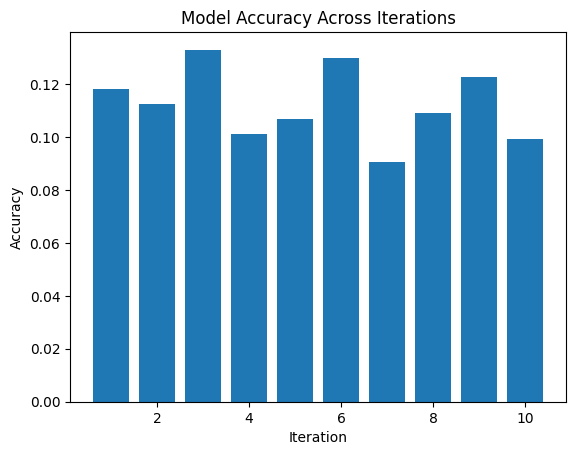

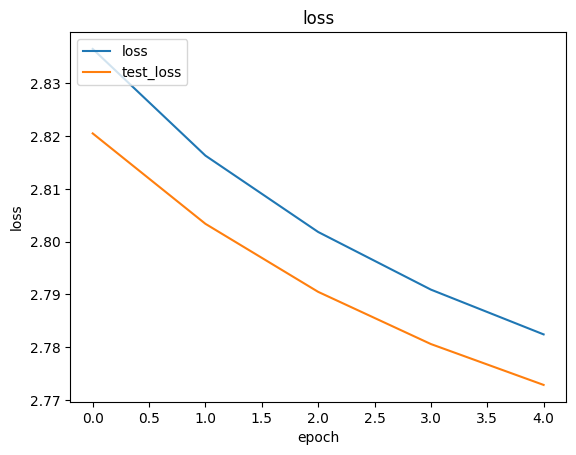

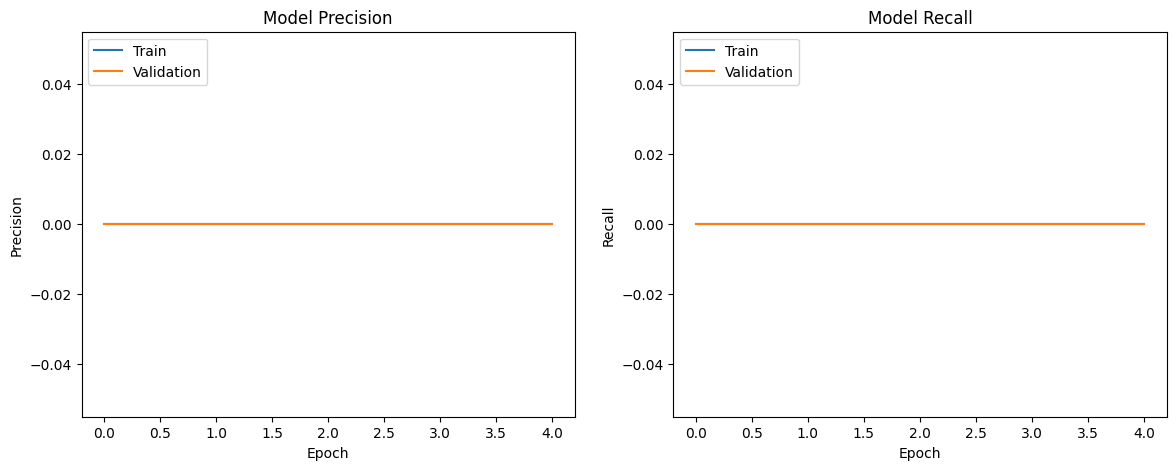

In [224]:
bonus("mlp", 13, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)